Notebook servant à faire l'augmentation de données pour le jeu de données de régression.

Les données sont des images de colonnes de rolls détourées. complétées par des pixels noirs.

lexique:
- valeur: le nombre de rolls dans une image
- nombre d'instances d'une valeur = nombre d'images avec \<valeur> rolls

In [20]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import albumentations as A

import json

from glob import glob
from random import randrange
import os
from tqdm import tqdm
import shutil
import re
import pandas as pd

import statistics
import numpy as np

## Initialisation des chemins utilisés

In [21]:
name = 'R5' # Le nom du dossier final sera regression_datatset_<name>

equilibrate = True # Si true, équilibre le nombre d'instance pour avoir le même nombre pour chaque valeur

'''
num_aug_max: int
Le nombre d'images maximum crée par la première transformation pour chaque image source, 
peut être réduit si 'equilibrate = True' pour certaines images sources
'''
num_aug_max = 6

'''
src_dir: str
Dossier source avec sous dossiers "images" et "labels" et fichier notes.json
'''
src_dir = "source"

'''
reg_res_path: str
Dossier de sortie

reg_res_path
|- train
|   |- img1.jpg
|   |- img2.jpg
|   |- ...
|   |-file.json
|- val
|   |- img1.jpg
|   |- img2.jpg
|   |- ...
|   |-file.json
|- test
|   |- ...
'''
reg_res_path = "regression_datatset_" + name

## Augmentation

Penser à modifier le chemin d'accès au données source si changements

L'augmentation est faite en 2 étapes, une première avec des augmentation non systématiques (c'est à dire qu'elles ont des probabilité de ne pas ce produire) et une deuxième étape avec des augmentation systématiques (miroir entre autre)

### Mise en place du dossier

In [22]:
# création des dossier et des sous-dossiers
splits = []
for split in ['test', 'val', 'train']:
    if split in os.listdir(src_dir):
        splits .append(split)

if reg_res_path:
    try:
        os.mkdir(reg_res_path)
    except OSError as error:  
        print(error)
    for split in splits:
        try:
            os.mkdir(os.path.join(reg_res_path, split))
        except OSError as error:  
            print(error)

[WinError 183] Impossible de créer un fichier déjà existant: 'regression_datatset_R5'
[WinError 183] Impossible de créer un fichier déjà existant: 'regression_datatset_R5\\val'
[WinError 183] Impossible de créer un fichier déjà existant: 'regression_datatset_R5\\train'


### Copie des données val et test

In [23]:
splits = []
for split in ['test', 'val']:
    if split in os.listdir(src_dir):
        splits .append(split)
        
for split in splits:
    src_path = os.path.join(src_dir, split)
    targ_path = os.path.join(reg_res_path, split)
    for file in tqdm(glob('*.jpg', dir_fd=src_path), desc = 'files copied'):
        shutil.copy2(os.path.join(src_path, file), targ_path)
    json_name = fname = glob('*.json', dir_fd=src_path)[0]
    with open(os.path.join(src_path, json_name)) as json_f:
            json_data = json.load(json_f)
            labels_dict = {}
            for data_field in json_data:
                text = os.path.basename(data_field['captioning']) # keep only file name
                img_name = re.search('-(.*)', text).group(1)
                labels_dict[img_name] = int(data_field['caption'])
    with open(os.path.join(targ_path, 'labels.json'), 'w') as res_json:
        json.dump(labels_dict, res_json)

files copied: 100%|██████████| 89/89 [00:00<00:00, 754.29it/s]


### Création des données augmentées

In [24]:
# dossier cibles
img_src_path = os.path.join(src_dir, 'train')
img_reg_res_path = os.path.join(reg_res_path, 'train')
images = glob('*.jpg', dir_fd=img_src_path)

# lier labels et images
json_name = fname = glob('*.json', dir_fd=img_src_path)[0]
with open(os.path.join(img_src_path, json_name)) as json_f:
        json_data = json.load(json_f)
        labels_dict = {}
        for data_field in json_data:
            text = os.path.basename(data_field['captioning']) # keep only file name
            img_name = re.search('-(.*)', text).group(1) # ne garde sue la fin du nom du fichier dans le json (car label-studio chenge le nom des imaegs en ajoutant un identifiant)
            labels_dict[img_name] = int(data_field['caption'])

# préparation si on souhaite équilibreer les valeurs
labels_list = labels_dict.values()
labels_count = pd.DataFrame(labels_list, columns=["x"]).groupby('x').size().to_dict() # compte le nombre d'instance pour chaque valeur
min_count = min(labels_count, key=labels_count.get)
max_nb_images = max(labels_count[min_count]*(num_aug_max+1), max(labels_count.values())) # nombre d'instance par valeur dans le dataset final
labels_nb_aug_dict = {} # dictionnaire qui donne le nombre d'augmentation de base pour chaque valeur
for key in labels_count.keys():
      labels_nb_aug_dict[key] = max_nb_images//labels_count[key]-1
bonus_img_gen = {}     # dictionnaire qui donne le nombre d'augmentation bonus pour avoir exactement le même nombre d'instances par valeur à la fin (ajoutera une image pour certaines image de certaines valeurs)
for key in labels_count.keys():
      bonus_img_gen[key] = max_nb_images - labels_count[key]*(labels_nb_aug_dict[key]+1)

In [25]:
labels_count

{1: 15,
 2: 33,
 3: 18,
 4: 106,
 5: 12,
 6: 16,
 7: 12,
 8: 37,
 10: 16,
 11: 16,
 12: 4,
 14: 4,
 16: 4}

In [26]:
# transformations
transform1 = A.Compose(
    [
        # Pixels
        A.RandomBrightnessContrast(p=0.2),
        A.RandomGamma(p=0.2),
        A.ISONoise(p=0.2),
        A.GaussNoise(p=0.2),
        A.CLAHE(p=0.2), # add contrast
        A.RandomSunFlare(src_radius = 10, num_flare_circles_upper= 8, p=0.1), # attention au rayon, si trop grand peut entièrement caché une boite
        A.RandomSunFlare(src_radius = 10, num_flare_circles_upper= 8, p=0.1),
        A.RandomSunFlare(src_radius = 10, num_flare_circles_upper= 8, p=0.1), # plusieur pour avoir different angles (ils se forment en ligne)
        
        # Spatial
        A.Rotate(limit=(-10, 10), p=0.3), # garder des angles raisonnables
        A.PixelDropout(dropout_prob=0.01 ,p=0.5),
    ]
)

transform2 = A.Compose(
    [
        A.HorizontalFlip(p=1),
    ]
)

# Boucle d'augmentation des images
for img_name in tqdm(images, desc = 'images processed'):
    '''
    Lecture des fichiers sources avec récupération des boîtes englobantes
    '''
    image = cv2.imread(os.path.join(img_src_path, img_name)) # lire l'image
    label = labels_dict[img_name] # récupérer son annotation
    if equilibrate: # détermine le nombre d'augmentations si on veux équilibrer
        num_aug = labels_nb_aug_dict[label]
        if bonus_img_gen[label] != 0: # +1 si il reste des compléments à faire
            num_aug +=1
            bonus_img_gen[label] -= 1
    else:
        num_aug = num_aug_max
    
    # copie de l'image source
    shutil.copy2(os.path.join(img_src_path, img_name), img_reg_res_path)

    '''
    Création des images augmentées:
        - transformation
        - miroir de l'originale
        - miroir de la transformée
    '''
    for ind in range(num_aug):
        transformed = transform1(image=image)
        transformed_mirror = transform2(image=transformed['image'])
        cv2.imwrite(os.path.join(img_reg_res_path, "transformed_" + str(ind) + "_" + img_name), transformed['image'])
        labels_dict["transformed_" + str(ind) + "_" + img_name] = label
        cv2.imwrite(os.path.join(img_reg_res_path, "transformed_miroir_" + str(ind) + "_" + img_name), transformed_mirror['image'])
        labels_dict["transformed_miroir_" + str(ind) + "_" + img_name] = label
    mirror = transform2(image=image)
    cv2.imwrite(os.path.join(img_reg_res_path, "miroir_" + img_name), mirror['image'])
    labels_dict["miroir_" + img_name] = label

    # sauvegarde des labels
    with open(os.path.join(img_reg_res_path, 'labels.json'), 'w') as res_json:
        json.dump(labels_dict, res_json)

images processed:   0%|          | 0/293 [00:00<?, ?it/s]

images processed: 100%|██████████| 293/293 [00:16<00:00, 17.69it/s]


# Inspection of Data distribution

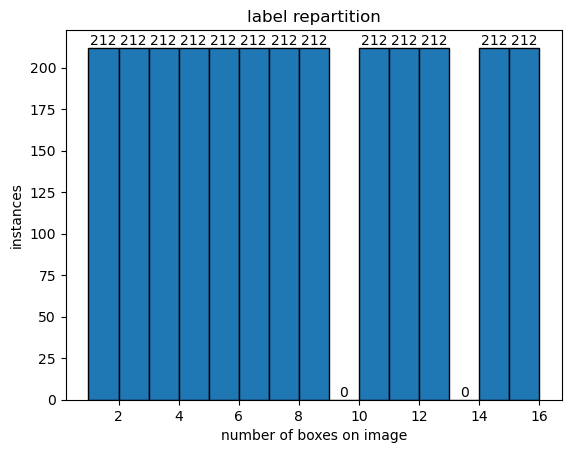

moyenne de longeur des rangés:  7.615384615384615
nombre d'images dans le dataset final:  2756


In [27]:
def parse_json(path):
    """Analyse le fichier json du dataset final

    Args:
        path str: Chemin vers le fichier json

    Returns:
        list: Liste des valeurs des annotations du jeu de donné
    """
    fname = glob('*.json', dir_fd=path)[0]
    with open(os.path.join(path, fname)) as json_f:
        json_data = json.load(json_f)
        labels = list(json_data.values())
    return labels

path = os.path.join(reg_res_path, 'train')
data = parse_json(path)
bins = np.linspace(min(data), max(data), max(data))
counts, edges, bars = plt.hist(data, bins, alpha=1, histtype='bar', ec='black')
plt.bar_label(bars)
plt.title('label repartition')
plt.xlabel('number of boxes on image')
plt.ylabel('instances')
plt.show()

print('moyenne de longeur des rangés: ', statistics.mean(data))
print("nombre d'images dans le dataset final: ", len(data))